# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем данные из соревнования [House Prices: Advanced Regression Techniques.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [72]:
# Будем использовать только обучающую выборку
data = pd.read_csv("C:/Users/Iana/Downloads/Video_Games.csv")
    #"C:/Users/Iana/Downloads/NEO Earth Close Approaches.csv")
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [73]:
# размер набора данных
data.shape

(16719, 16)

In [74]:
# типы колонок
data.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

In [77]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [78]:
# Первые 5 строк датасета
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 16719


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [80]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((16719, 16), (16719, 6))

In [81]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((16719, 16), (6825, 16))

In [82]:
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,0.0,0.0,0,0.0,0,0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,0.0,0.0,0,0.0,0,0


## "Внедрение значений" - импьютация (imputation)

### Обработка пропусков в числовых данных

In [84]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Year_of_Release. Тип данных float64. Количество пустых значений 269, 1.61%.
Колонка Critic_Score. Тип данных float64. Количество пустых значений 8582, 51.33%.
Колонка Critic_Count. Тип данных float64. Количество пустых значений 8582, 51.33%.
Колонка User_Count. Тип данных float64. Количество пустых значений 9129, 54.6%.


In [85]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,Year_of_Release,Critic_Score,Critic_Count,User_Count
0,2006.0,76.0,51.0,322.0
1,1985.0,NaN,NaN,NaN
2,2008.0,82.0,73.0,709.0
3,2009.0,80.0,73.0,192.0
4,1996.0,NaN,NaN,NaN
...,...,...,...,...
16714,2016.0,NaN,NaN,NaN
16715,2006.0,NaN,NaN,NaN
16716,2016.0,NaN,NaN,NaN
16717,2003.0,NaN,NaN,NaN


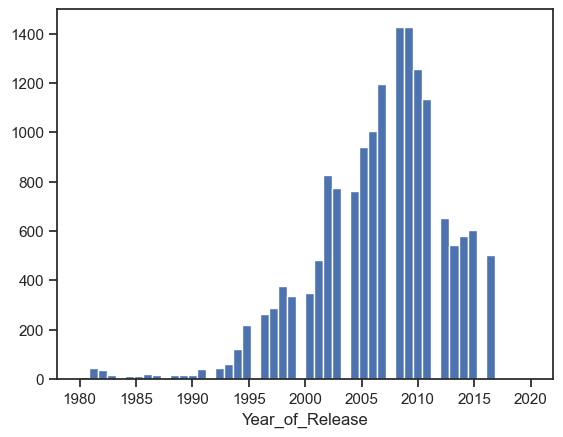

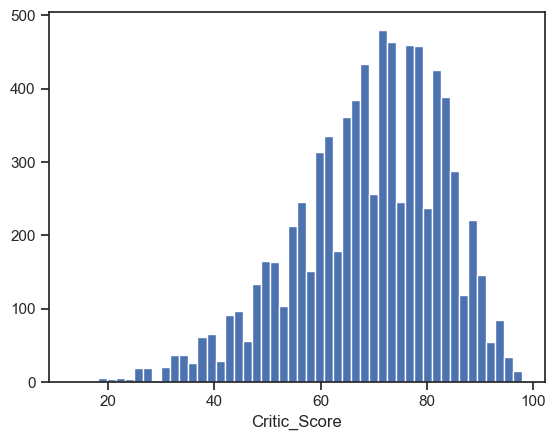

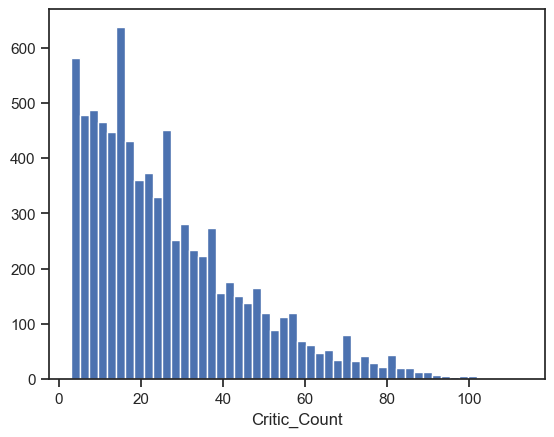

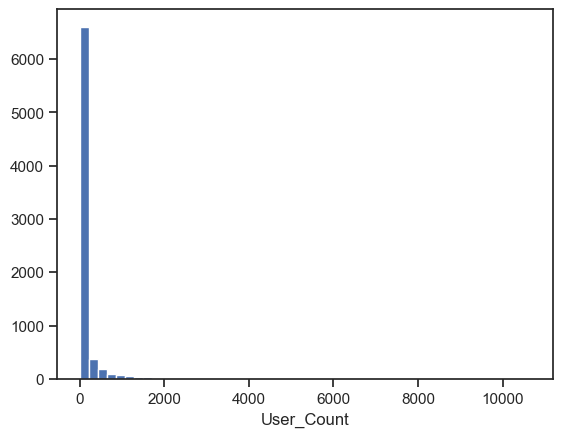

In [86]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

In [87]:
data_num_year = data_num[['Year_of_Release']]
data_num_year.head()

,Year_of_Release
0,2006.0
1,1985.0
2,2008.0
3,2009.0
4,1996.0


In [88]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [90]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_year)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [91]:
strategies=['mean', 'median', 'most_frequent']

In [92]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_year)
    return data_num_imp[mask_missing_values_only]

In [93]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2006.48735562, 2006.48735562,
        2006.48735562, 2006.48735562, 2

In [94]:
strategies[1], test_num_impute(strategies[1])

('median',
 array([2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 20

In [95]:
strategies[2], test_num_impute(strategies[2])

('most_frequent',
 array([2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008., 2008.,
        2008., 2008., 2008., 2008., 2008., 2008., 2008., 20

In [96]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [98]:
data[['User_Count']].describe()

,User_Count
count,7590.000000
mean,162.229908
std,561.282326
min,4.000000
25%,10.000000
50%,24.000000
75%,81.000000
max,10665.000000


In [99]:
test_num_impute_col(data, 'User_Count', strategies[0])

('User_Count', 'mean', 9129, 162.22990777338603, 162.22990777338603)

In [100]:
test_num_impute_col(data, 'User_Count', strategies[1])

('User_Count', 'median', 9129, 24.0, 24.0)

In [103]:
test_num_impute_col(data, 'User_Count', strategies[2])

('User_Count', 'most_frequent', 9129, 4.0, 4.0)

### Обработка пропусков в категориальных данных

In [104]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Name. Тип данных object. Количество пустых значений 2, 0.01%.
Колонка Genre. Тип данных object. Количество пустых значений 2, 0.01%.
Колонка Publisher. Тип данных object. Количество пустых значений 54, 0.32%.
Колонка User_Score. Тип данных object. Количество пустых значений 6704, 40.1%.
Колонка Developer. Тип данных object. Количество пустых значений 6623, 39.61%.
Колонка Rating. Тип данных object. Количество пустых значений 6769, 40.49%.


**Какие из этих колонок Вы бы выбрали или не выбрали для построения модели?**

Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [105]:
cat_temp_data = data[['Rating']]
cat_temp_data.head()

,Rating
0,E
1,NaN
2,E
3,E
4,NaN


In [106]:
cat_temp_data['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [107]:
cat_temp_data[cat_temp_data['Rating'].isnull()].shape

(6769, 1)

In [108]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['E'],
       ['E'],
       ['E'],
       ...,
       ['E'],
       ['E'],
       ['E']], dtype=object)

In [109]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T'], dtype=object)

In [110]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='median')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['E'],
       ['median'],
       ['E'],
       ...,
       ['median'],
       ['median'],
       ['median']], dtype=object)

In [111]:
np.unique(data_imp3)

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', 'median'],
      dtype=object)

In [112]:
data_imp3[data_imp3=='NA'].size

0

# Преобразование категориальных признаков в числовые

In [113]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,E
1,E
2,E
3,E
4,E
...,...
16714,E
16715,E
16716,E
16717,E


## Кодирование категорий целочисленными значениями (label encoding)

В этом случае уникальные значения категориального признака кодируются целыми числами.

В scikit-learn для такого кодирования используется два класса :

- [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) - который ориентирован на применение к одному признаку. Этот класс прежде всего предназначен для кодирования целевого признака, но может быть также использован для последовательного кодирования отдельных нецелевых признаков.
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - который ориентирован на применение к матрице объект-признак, то есть для кодирования матрицы нецелевых признаков.

### Использование LabelEncoder

In [114]:
from sklearn.preprocessing import LabelEncoder

In [115]:
cat_enc['c1'].unique()

array(['E', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [116]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [117]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем 
# задачу классификации и каждое значение категории соответствует 
# какому-либо классу целевого признака

le.classes_

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T'], dtype=object)

In [118]:
cat_enc_le

array([1, 1, 1, ..., 1, 1, 1])

In [119]:
np.unique(cat_enc_le)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [120]:
# В этом примере видно, что перед кодированием 
# уникальные значения признака сортируются в лексикографиеском порядке
le.inverse_transform([0, 1, 2, 3])

array(['AO', 'E', 'E10+', 'EC'], dtype=object)

### Использование OrdinalEncoder

In [121]:
from sklearn.preprocessing import OrdinalEncoder

In [128]:
data_oe = data[['Rating']]
data_oe.head()

,Rating
0,E
1,NaN
2,E
3,E
4,NaN


In [129]:
imp4 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_oe_filled = imp4.fit_transform(data_oe)
data_oe_filled

array([['E'],
       ['NA'],
       ['E'],
       ...,
       ['NA'],
       ['NA'],
       ['NA']], dtype=object)

In [130]:
oe = OrdinalEncoder()
cat_enc_oe = oe.fit_transform(data_oe_filled)
cat_enc_oe

array([[1.],
       [6.],
       [1.],
       ...,
       [6.],
       [6.],
       [6.]])

In [131]:
# Уникальные значения 1 признака
np.unique(cat_enc_oe[:, 0])

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [133]:
# Уникальные значения 2 признака
#np.unique(cat_enc_oe[:, 1])

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [134]:
# Уникальные значения 3 признака
#np.unique(cat_enc_oe[:, 1])

IndexError: index 2 is out of bounds for axis 1 with size 1

In [135]:
# Наименования категорий в соответствии с порядковыми номерами
oe.categories_

[array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'NA', 'RP', 'T'], dtype=object)]

In [136]:
# Обратное преобразование
oe.inverse_transform(cat_enc_oe)

array([['E'],
       ['NA'],
       ['E'],
       ...,
       ['NA'],
       ['NA'],
       ['NA']], dtype=object)

### Проблемы использования LabelEncoder и OrdinalEncoder

Необходимо отметить, что LabelEncoder и OrdinalEncoder могут использоваться только для категориальных признаков в номинальных шкалах (для которых отсутствует порядок), например города, страны, названия рек и т.д. 

Это связано с тем, что задать какой-либо порядок при кодировании с помощью LabelEncoder и OrdinalEncoder невозможно, они сортируют категории в лексикографическом порядке.

При этом кодирование целыми числами создает фиктивное отношение порядка (1 < 2 < 3 < ...) которого не было в исходных номинальных шкалах. Данное отношение порядка может негативно повлиять на построение модели машинного обучения.

### Кодирование шкал порядка

Библиотека scikit-learn не предоставляет готового решения для кодирования шкал порядка, но можно воспользоваться [функцией map для отдельных объектов Series.](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [ ]:
# пример шкалы порядка 'small' < 'medium' < 'large'
sizes = ['small', 'medium', 'large', 'small', 'medium', 'large', 'small', 'medium', 'large']

In [ ]:
pd_sizes = pd.DataFrame(data={'sizes':sizes})
pd_sizes

In [ ]:
pd_sizes['sizes_codes'] = pd_sizes['sizes'].map({'small':1, 'medium':2, 'large':3})
pd_sizes

In [ ]:
pd_sizes['sizes_decoded'] = pd_sizes['sizes_codes'].map({1:'small', 2:'medium', 3:'large'})
pd_sizes

## Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

В этом случае каждое уникальное значение признака становится новым отдельным признаком.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [ ]:
cat_enc.shape

In [ ]:
cat_enc_ohe.shape

In [ ]:
cat_enc_ohe

In [ ]:
cat_enc_ohe.todense()[0:10]

In [ ]:
cat_enc.head(10)

## [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [ ]:
pd.get_dummies(cat_enc).head()

In [ ]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [ ]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['SalePrice']])

In [ ]:
plt.hist(data['SalePrice'], 50)
plt.show()

In [ ]:
plt.hist(sc1_data, 50)
plt.show()

## Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [ ]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['SalePrice']])

In [ ]:
plt.hist(sc2_data, 50)
plt.show()

# Дополнительные источники
- [Руководство scikit-learn по предобработке данных](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Kaggle Data Cleaning Challenge: Handling missing values (упражнения с пояснениями по обработке пропущенных значений и масштабированию признаков)](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)
- [Краткое руководство по категориальным признакам](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)